# Is a good beer a good beer everywhere?

In the following notebook, we explore the idea of how liked beers differ locally and globally. We start by extracting the data and preprocessing it in a way that makes it easier to compare locations of beers and breweries.

In [1]:
import pandas as pd
import numpy as np
import gzip #to read gzip files
import matplotlib.pyplot as plt
import datetime
import pickle

## Data extraction and viewing

We start by extracting the data for beers, breweries and users from the two rating websites BeerAdvocate and RateBeer as well as the matched data. We view the dataframe first few rows to get a sense of what the data contains.

In [2]:
PATH = '../'

### BeerAdvocate data

In [7]:
BA_beers = pd.read_csv(PATH+'BeerAdvocate/beers.csv', index_col='beer_id')
BA_beers.head(2)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,,
166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN


In [8]:
matched_beers = pd.read_csv(PATH+'matched_beer_data/beers.csv', header=1)
matched_beers.head(2)

,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id.1,brewery_name.1,nbr_matched_valid_ratings.1,nbr_ratings.1,overall_score,style.1,style_score,zscore.1,diff,sim
0,4.8,3.45,3.439867,3.504068,80.0,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.698304,1.000000,1.0
1,6.0,3.86,3.888750,3.768333,NaN,20841,St. Patrick's Ale,Patricks Ale St,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,11,11,52.0,Irish Ale,79.0,0.005754,0.527141,1.0


In [29]:
BA_breweries = pd.read_csv(PATH+'BeerAdvocate/breweries.csv', index_col='id')

BA_breweries['merged_location'] = BA_breweries['location'].copy()
BA_breweries.loc[(BA_breweries['merged_location'].str.startswith('United States')), 'merged_location'] = 'United States'

BA_breweries.head(2)


,location,name,nbr_beers,merged_location
id,,,,
39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5,Kyrgyzstan
39913,Kyrgyzstan,Arpa (АРПА),1,Kyrgyzstan


### RateBeer data

In [28]:
RB_breweries = pd.read_csv(PATH+'RateBeer/breweries.csv', index_col= 'id')

# Add a column where all Users from the united states get 'United States' as location
RB_breweries['merged_location'] = RB_breweries['location'].copy()
RB_breweries.loc[(RB_breweries['merged_location'].str.startswith('United States')), 'merged_location'] = 'United States'

RB_breweries.head(2)

In [15]:
matched_breweries = pd.read_csv(PATH+'matched_beer_data/breweries.csv', header=1)
matched_breweries.head(2)

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim
0,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,Northern Ireland,Strangford Lough,5,0.431275,0.889062
1,32848,Northern Ireland,The Sheelin Brewery,4,17616,Northern Ireland,Sheelin,2,0.526388,0.863596


In [27]:
BA_users = pd.read_csv(PATH+'BeerAdvocate/users.csv', index_col= 'user_id')
BA_users['joined'] = pd.to_datetime(BA_users['joined'],unit = 's')
BA_users.head(2)

# Add a column where all Users from the united states get 'United States' as location
BA_users['location'] = BA_users['location'].fillna('Unknown')
BA_users['merged_location'] = BA_users['location'].copy()
BA_users.loc[(BA_users['merged_location'].str.startswith('United States')), 'merged_location'] = 'United States'

In [13]:
RB_users = pd.read_csv(PATH+'RateBeer/users.csv', index_col= 'user_id')
RB_users['joined'] = pd.to_datetime(RB_users['joined'] ,unit = 's')
RB_users.head(2)

# Add a column where all Users from the united states get 'United States' as location
RB_users['location'] = RB_users['location'].fillna('Unknown')
RB_users['merged_location'] = RB_users['location'].copy()
RB_users.loc[(RB_users['merged_location'].str.startswith('United States')), 'merged_location'] = 'United States'

,nbr_ratings,user_name,joined,location
user_id,,,,
175852,1890,Manslow,2012-05-20 10:00:00,Poland
442761,89,MAGICuenca91,2017-01-10 11:00:00,Spain


### Matched data

In [14]:
matched_users = pd.read_csv(PATH+'matched_beer_data/users.csv', header=1)
matched_users['joined'] = pd.to_datetime(matched_users['joined'],unit = 's')
matched_users['joined.1'] = pd.to_datetime(matched_users['joined.1'],unit = 's')
matched_users.head(2)

,joined,location,nbr_ratings,nbr_reviews,user_id,user_name,user_name_lower,joined.1,location.1,nbr_ratings.1,user_id.1,user_name.1,user_name_lower.1
0,2008-09-08 10:00:00,Germany,6,6,erzengel.248045,Erzengel,erzengel,2008-10-18 10:00:00,Germany,8781,83106,Erzengel,erzengel
1,2012-09-23 10:00:00,"United States, Virginia",1,1,gendv138.695700,GenDV138,gendv138,2013-11-29 11:00:00,"United States, Virginia",6240,290599,GenDV138,gendv138


Next we extract the reviews from the different datasets. Since those are very large text files, we first converted them into the appropriate csv format and added those csv files into our data. Below we just read them:

### Extracting BeerAdvocate reviews

In [3]:
#open the csv file
df_BA_reviews = pd.read_csv('../BeerAdvocate/df_BA_reviews.csv')
df_BA_reviews = pd.read_csv('../DataframeStorage/df_BA_reviews.csv')
df_BA_reviews.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,brewery_location,brewery_merged_location,user_location,user_merged_location
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",Gabon,Gabon,"United States, Washington",United States
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,Northern Ireland,Northern Ireland,"United States, New York",United States


### Extracting RateBeer reviews:

In [4]:
#open the csv file
#df_RB_reviews = pd.read_csv('../RateBeer/df_RB_reviews_final.csv')
df_RB_reviews = pd.read_csv('../DataframeStorage/df_RB_reviews.csv')
df_RB_reviews.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,brewery_location,brewery_merged_location,user_location,user_merged_location
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło...",Gabon,Gabon,Poland,Poland
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...,Gabon,Gabon,Spain,Spain


In [ ]:
df_reviews_all = pd.read_csv(PATH+'/DataframeStorage/df_reviews_all.csv')

The dates in df_reviews are saved as strings. <br>
A first step (will be important later) is to transform them to datetime. <br>
Probably this step we will have to do everytime we load the csv file.

In [5]:
#Transform the dates of the reviews from string to datetime
df_BA_reviews['date'] = pd.to_datetime(df_BA_reviews['date'], format="%Y-%m-%d %H:%M:%S")
df_RB_reviews['date'] = pd.to_datetime(df_RB_reviews['date'], format="%Y-%m-%d %H:%M:%S")

# Some preprocessing <br>
## Run these cells only once, then save the dataframe. <br>
## Afterwards you can just load the dataframes and don't loose time to run all the computations again

To allow the merge of the brewery location with the brewery name on df_reviews, we first need to align the column names. <br>
To do so we rename the column "name" of breweries to "brewery_name" (the name of the column in df_reviews). <br>

We use the function df.merge to add the element "location" to the corresponding brewery in df_reviews. <br>
By default the new columns name would be the same as in df_breweries ('location'), we rename it by "brewery_location" to prevent confusion. <br>

After the merging we rename the column of the brewery dataframe again, to have the same name that we had initially.

In [15]:
#Rename the column name to brewery_name to allow merging with the 
BA_breweries.rename(columns = {'name':'brewery_name'}, inplace = True)
RB_breweries.rename(columns = {'name':'brewery_name'}, inplace = True)


#Add the location to the beer dataframe
df_BA_reviews = (df_BA_reviews.merge(BA_breweries[['location', 'brewery_name']], on=['brewery_name'], how='left')).rename(columns = {'location':'brewery_location'})
df_RB_reviews = (df_RB_reviews.merge(RB_breweries[['location', 'brewery_name']], on=['brewery_name'], how='left')).rename(columns = {'location':'brewery_location'})


#Name the columns back: 
BA_breweries.rename(columns = {'brewery_name':'name'}, inplace = True)
RB_breweries.rename(columns = {'brewery_name':'name'}, inplace = True)

As the different states of the US are described as different locations, but sometimes we want to group the beers by nations and not by states. <br>
To make this possible we add a new column. <br>
This column is called "brewery_merged_location" and is exactly the same as the column "brewery_location" except for the fact, that the different states of the US all take the value "United States".

In [16]:
# Add a column where all breweries from the united states get 'United States' as location
df_RB_reviews['brewery_merged_location'] = df_RB_reviews['brewery_location'].copy()
df_RB_reviews.loc[(df_RB_reviews['brewery_merged_location'].str.startswith('United States')), 'brewery_merged_location'] = 'United States'


df_BA_reviews['brewery_merged_location'] = df_BA_reviews['brewery_location'].copy()
df_BA_reviews.loc[(df_BA_reviews['brewery_merged_location'].str.startswith('United States')), 'brewery_merged_location'] = 'United States'

The same approach as for the brewery locations is used to add the country of origin of the users. <br>
To group them by nations we add here a column that sums up the states of the US under the value "United States".

In [17]:
#Add the country of origin of the reviewer to the review
df_RB_reviews = (df_RB_reviews.merge(RB_users[['location', 'user_name']], on=['user_name'], how='left')).rename(columns={'location':'user_location'})
df_BA_reviews = (df_BA_reviews.merge(BA_users[['location', 'user_name']], on=['user_name'], how='left')).rename(columns={'location':'user_location'})

# Add a column where all users from the united states get 'United States' as location
df_RB_reviews['user_location'] = df_RB_reviews['user_location'].fillna('Unknown')
df_RB_reviews['user_merged_location'] = df_RB_reviews['user_location'].copy()
df_RB_reviews.loc[(df_RB_reviews['user_merged_location'].str.startswith('United States')), 'user_merged_location'] = 'United States'

#For BA we have to replace the NaN values
df_BA_reviews['user_location'] = df_BA_reviews['user_location'].fillna('Unknown')
df_BA_reviews['user_merged_location'] = df_BA_reviews['user_location'].copy()
df_BA_reviews.loc[(df_BA_reviews['user_merged_location'].str.startswith('United States')), 'user_merged_location'] = 'United States'

In [28]:
# Add a column where all users from the united states get 'United States' as location
df_RB_reviews['user_location'] = df_RB_reviews['user_location'].fillna('Unknown')

df_RB_reviews['user_merged_location'] = df_RB_reviews['user_location'].copy()
df_RB_reviews.loc[(df_RB_reviews['user_merged_location'].str.startswith('United States')), 'user_merged_location'] = 'United States'

To avoid doing this computations every time we want to start coding, I suggest to save the dataframes in your data folder. <br>
I separated the code into two cells as the computation can take several minutes.

In [23]:
#Do that only once. Stores the dataframes so that we can access them more easily next time and have to do the data preprocessing only once
df_BA_reviews.to_csv(PATH+'/DataframeStorage/df_BA_reviews.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location'], index=False)

In [29]:
df_RB_reviews.to_csv(PATH+'/DataframeStorage/df_RB_reviews.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location'], index=False)

In [5]:
df_reviews_all = pd.concat([df_BA_reviews, df_RB_reviews], axis=0)

df_reviews_all.to_csv(PATH+'/DataframeStorage/df_reviews_all.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location'], index=False)

### Extracting matched data ratings

In [38]:
MD_ratings = pd.read_csv(PATH+'matched_beer_data/ratings.csv', header = 1)
MD_ratings.head(2)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name.1,date.1,overall.1,palate.1,rating.1,style.1,taste.1,text.1,user_id.1,user_name.1
0,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,...,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106,Erzengel
1,5.0,NaN,NaN,28191,Myanmar Lager Beer,9369,Myanmar Brewery and Distillery,1322650800,NaN,NaN,...,Myanmar Brewery and Distillery,1322564400,6.0,2.0,1.7,Pale Lager,4.0,"Can. Weak and watery, not the best beer of the...",91324,visionthing


## Exploring the feasability of the following idea : Is a good beer a good beer everywhere? In other words, do people tend to like beers that are produced locally or are they more inclined to drink a good beer no matter where it is produced?

### Choosing the 20 best beers in the world

The aim of this idea is to choose the top 20 beers in the world and compare locations of users and the brewery locations for the beers in order to see if there is a bias towards local beers.
In order to choose the best beers, we have decided on a certain number of criteria:
1) Beers that have receieved at least x (to be determined below based on statistical information) number of reviews
2) Reviewers that have reviewed more than x (to be determined below based on statistical information) amount of times (if someone rated a beer once only it's maybe not enough), also we have to keep in mind that a lot of people mindlessly rate beers without reviewing them. Hence here we focus on the number of reviews because it means the person took the time and effort to write a review, making the overall rating more legitimate.
3) Extract the top 20 beers according to the average rating across the two websites.

For those ideas, we use the matched data and the average rating between the two websties for the 3).

### 1) Beers that have recieved a significant number of reviews

First, let's take a look at the distribution of the number of reviews per beer to get a sense of how the x minimal number of reviews a beer should've received in order to select it.

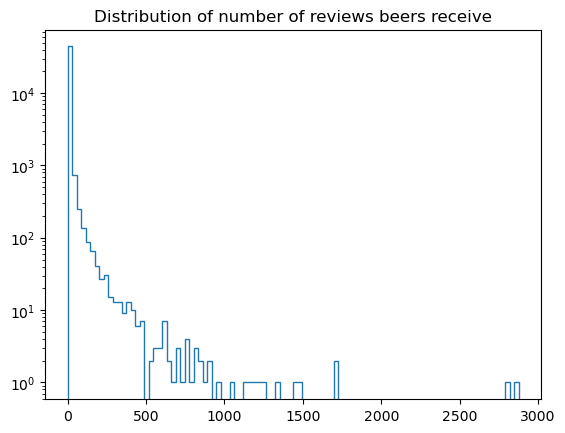

In [14]:
array_100=plt.hist(matched_beers['nbr_reviews'], bins=100,log=True,histtype='step')
plt.title('Distribution of number of reviews beers receive')
plt.show()

In [15]:
matched_beers['nbr_reviews'].describe()

count    45640.000000
mean         5.977826
std         40.955440
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max       2875.000000
Name: nbr_reviews, dtype: float64

From the statistical description above, we can see that the quantiles are not very interesting for the choice of our treshold since this is a heavy tailed distribution and 75% of the beers have at most 2 reviews. So we choose to take the beers that have received at least 50 reviews which represents around 2% of the data 

In [34]:
print(f'{"Percentage of beer data with more than 50 reviews :"} { round(len(matched_beers[matched_beers["nbr_reviews"]>50])/len(matched_beers["nbr_reviews"])*100,2) }{"%"}')
print(f'{"Number of beers with more than 50 reviews :"} { len(matched_beers[matched_beers["nbr_reviews"]>50]) }')

Percentage of beer data with more than 50 reviews : 1.95%
Number of beers with more than 50 reviews : 890


In [37]:
# Extracting beers which have received more than 50 reviews
top_beers = matched_beers[matched_beers['nbr_reviews']>50]

In [39]:
#We extract the corresponding ratings/reviews from matched data 
top_beers_ratings = MD_ratings[MD_ratings['beer_id'].isin(top_beers['beer_id']) | MD_ratings['beer_id.1'].isin(top_beers['beer_id.1'])]

### 2) Reviewers that have reviewed more than x amount of times 

Now that we've constructed the dataframe *top_beers_ratings* with the ratings for the beers that are heavily reviewed, we want to look into the reviewers and start by extracting the revieweres who reviewed those beers.

In [72]:
#we extract the users that reviewed the beers that have received more than 50 reviews.
top_beers_reviewers = matched_users[matched_users['user_id'].isin(top_beers_ratings['user_id']) | matched_users['user_id.1'].isin(top_beers_ratings['user_id.1'])]

Let's take a look at the number of ratings per reviewer for the reviewers of the highly reviewed beers: 

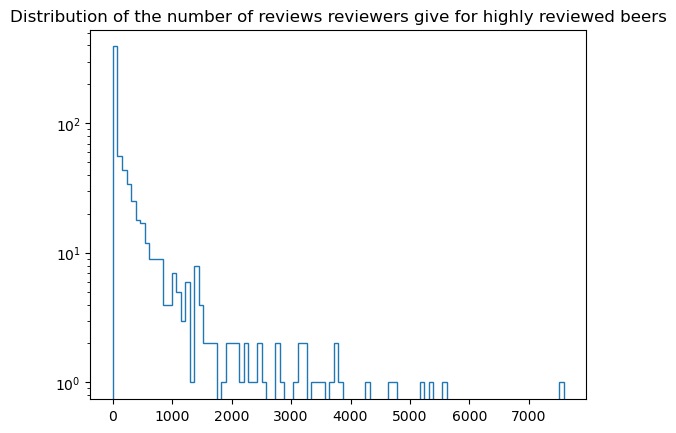

In [76]:
array_100=plt.hist(top_beers_reviewers['nbr_reviews'], bins=100,log=True,histtype='step')
plt.title('Distribution of the number of reviews reviewers give for highly reviewed beers')
plt.show()

In [74]:
top_beers_reviewers[['nbr_reviews']].describe()

,nbr_reviews
count,711.000000
mean,365.544304
std,804.331349
min,0.000000
25%,7.000000
50%,54.000000
75%,327.000000
max,7593.000000


Since the mean is close to the median, this is not a heavy tailed distribution (it may be an exponential distribution). Since here the 3rd percentile already represents a significant number of reviews, we choose to select reviewers who have written more than that amount of reviews (327).

In [77]:
#We decide to filter by the reviewers that have put a number of reviews (not ratings) higher than the third percentile
top_beers_reviewers = top_beers_reviewers.loc[top_beers_reviewers['nbr_reviews']>327]

Now we go back to the beers we've extracted earlier and subset them by the reviewers exctracted above

In [78]:
#filtering the beer ratings by the top beer reviewers
top_beers_ratings = top_beers_ratings[top_beers_ratings['user_id'].isin(top_beers_reviewers['user_id']) & top_beers_ratings['user_id.1'].isin(top_beers_reviewers['user_id.1']) ]

### 3) Extract top 20 beers according to the avg rating over the two websites

Now we really want to extract the top 20 beers after all that filtering. We do so by using the beer ratings. Since each website has an average rating the beers, we start by taking the average of these average ratings. Then we select the 20 beers with the highest ratings.

In [89]:
#adding an average of averages column to get the average rating across both websites
top_beers['average_avg'] = top_beers[['avg', 'avg.1']].mean(axis=1)
top_20_beers = top_beers.nlargest(20, 'average_avg', keep='all')

/var/folders/vs/4l5nyqs52cj8k63yp80d5cfh0000gn/T/ipykernel_22894/1016610164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_beers['average_avg'] = top_beers[['avg', 'avg.1']].mean(axis=1)


We subset the review dataframe with those specific beers:

In [90]:
#We extract the ratings for those top20 beers for the top reviewers
top_20_beers_ratings = top_beers_ratings[top_beers_ratings['beer_id'].isin(top_20_beers['beer_id']) & top_beers_ratings['beer_id.1'].isin(top_20_beers['beer_id.1'])]

In [91]:
#Sanity check to make sure that we do have 20 beers
top_20_beers_ratings[['beer_id','beer_id.1']].nunique()

beer_id      20
beer_id.1    20
dtype: int64

In [92]:
# Group by beer id's, since we'll have the same beers several times and both id's should correspond to the same beers. 
top_20_beers_ratings = top_20_beers_ratings.set_index(['beer_id','beer_id.1'])

In [100]:
top_20_beers_ratings.head(2)

Index(['abv', 'appearance', 'aroma', 'beer_name', 'brewery_id', 'brewery_name',
       'date', 'overall', 'palate', 'rating', 'review', 'style', 'taste',
       'text', 'user_id', 'user_name', 'abv.1', 'appearance.1', 'aroma.1',
       'beer_name.1', 'brewery_id.1', 'brewery_name.1', 'date.1', 'overall.1',
       'palate.1', 'rating.1', 'style.1', 'taste.1', 'text.1', 'user_id.1',
       'user_name.1'],
      dtype='object')

Since in the above top_20_beers_ratings dataframe we encounter the same beers several times, we want the unique beer id's for these 20 beers. We do so by running the following cell which drops duplicated of the indices:

In [ ]:
top_20_beers_ids = top_20_beers_ratings[~top_20_beers_ratings.index.duplicated(keep='first')].index
top_20_beers_ids = pd.MultiIndex.to_frame(top_20_beers_ids, index= False)

Finally we want to compare the location of the users compared to the location of the breweries. For this purpose we'll do it for both websites dataframes : *df_ratings_BA* and *df_ratings_RB*. <br>
First, we select from both datasets the locations of breweries and users for the top 20 beers:

In [ ]:
top_20_beers_BA = df_BA_reviews[df_BA_reviews['beer_id'].isin(top_20_beers_ids['beer_id'])][['beer_name','beer_id','brewery_location','user_location']]

In [ ]:
top_20_beers_RB = df_RB_reviews[df_RB_reviews['beer_id'].isin(top_20_beers_ids['beer_id.1'])][['beer_name','beer_id','brewery_location','user_location']]

To get an idea of how frequent it is that people drink locally made beers we calculate the percentage of entries for which the brewery location and user location are the same:

In [ ]:
print(f'{"Percentage of users on the BeerAdvocate website that drink local beers for the top 20 most liked beers across both websites:"} { round(np.count_nonzero(top_20_beers_BA["brewery_location"] == top_20_beers_BA["user_location"])/len(top_20_beers_BA)*100,2) }{"%"}')
print(f'{"Percentage of users on the RateBeer website that drink local beers for the top 20 most liked beers across both websites:"} { round(np.count_nonzero(top_20_beers_RB["brewery_location"] == top_20_beers_RB["user_location"])/len(top_20_beers_RB)*100,2) }{"%"}')

It's interesting to observe that in both websites the percentage of people who drink local beers when it comes the the most liked beers ever is very close

Since we could obtain a dataframe comparing locations of users and breweries, this idea is quite feasible and we can explore other ideas and visualizations with this information.
For the continuation of this part in milestone P3, we can perhaps explore other ideas such as : <br>
- The distance between beer drinkers and their respective breweries
- The location of the best breweries 
- Perhaps the reason behind the success of certain breweries compared to others

# Flos code:

## Chinas beers correlate with how US citizens view China:

In [17]:
print(len(RB_breweries[RB_breweries['location']=='China']))
print(len(BA_breweries[BA_breweries['location']=='China']))

188
66


In [23]:
chinese_breweries_RB = RB_breweries[RB_breweries['location']=='China']
chinese_breweries_BA = BA_breweries[BA_breweries['location']=='China']

In [21]:
#As the same breweries have not exactly the same wording, we concatenate the two dataframes.
chinese_breweries = pd.concat([chinese_breweries_RB['name'], (chinese_breweries_BA['name'])], axis=0)

id
29441    申爱 Shanghai Love Brewing Co.
Name: name, dtype: object

In [25]:
len(df_BA_reviews[df_BA_reviews['brewery_name'].isin([chinese_breweries])])

0

In [26]:
len(df_RB_reviews[df_RB_reviews['brewery_name'].isin([chinese_breweries])])

0

There are no ratings about chinese beers neither in BA nor in RB.

## Influence of Brexit on british reviews in the US:

First we check out from when to when we have data. The brexit referendum was in June 2016, to find any influence of the Brexit result on US beer ratings of british beer we need reviews before and after the votation.

In [29]:
print(df_BA_reviews.date.max())
print(df_BA_reviews.date.min())

2017-08-01 10:00:00
1996-08-22 10:00:00


In [30]:
print(df_RB_reviews.date.max())
print(df_RB_reviews.date.min())

2017-07-31 10:00:00
2000-04-12 10:00:00


### Get Reviews about british beer:

In [43]:
df_british_beers_RB = pd.read_csv(PATH+'/DataframeStorage/df_british_beers_RB.csv')
df_british_beers_BA = pd.read_csv(PATH+'/DataframeStorage/df_british_beers_RB.csv')

#Transform the column with the dates from string to datetime
df_british_beers_RB['date'] = pd.to_datetime(df_british_beers_RB['date'], format="%Y-%m-%d %H:%M:%S")
df_british_beers_BA['date'] = pd.to_datetime(df_british_beers_BA['date'], format="%Y-%m-%d %H:%M:%S")

In [44]:
df_british_beers_all = pd.concat([df_british_beers_BA, df_british_beers_RB], axis=0)

In [32]:
'''
df_british_beers_RB = df_RB_reviews[(df_RB_reviews['brewery_location']=='Northern Ireland') |
                                (df_RB_reviews['brewery_location']=='Wales')  |
                                (df_RB_reviews['brewery_location']=='Scotland') |
                                (df_RB_reviews['brewery_location']=='England')]

df_british_beers_BA = df_BA_reviews[(df_BA_reviews['brewery_location']=='Northern Ireland') |
                                (df_BA_reviews['brewery_location']=='Wales')  |
                                (df_BA_reviews['brewery_location']=='Scotland') |
                                (df_BA_reviews['brewery_location']=='England')]


df_british_beers_RB.to_csv(PATH+'/DataframeStorage/df_british_beers_RB.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location'], index=False)
df_british_beers_BA.to_csv(PATH+'/DataframeStorage/df_british_beers_BA.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location'], index=False)
'''

In [45]:
#count the number of reviews we can work with.
print('in RB we have: ' + str(len(df_british_beers_RB)) + ' reviews about british beer.')
print('in BA we have: ' + str(len(df_british_beers_BA)) + ' reviews about british beer.')
print('Which makes a total of: ' + str(len(df_british_beers_all)) + ' reviews about british beer.')

in RB we have: 774523 reviews about british beer.
in BA we have: 774523 reviews about british beer.
Which makes a total of: 1549046 reviews about british beer.


As we are interested in the influence of the brexit on the reviews of US users on british beer, we will only look at the reviews from US users.

In [47]:
df_british_beers_US_users = df_british_beers_all[df_british_beers_all['user_merged_location'] == 'United States']

In [48]:
print('Out of the ' + str(len(df_british_beers_all)) + ' reviews, ' + str(len(df_british_beers_US_users)) + ' are from users from the US')

Out of the 1549046 reviews, 210658 are from users from the US


We can see that unfortunately only a fraction of the reviews about the british beer is from the US.

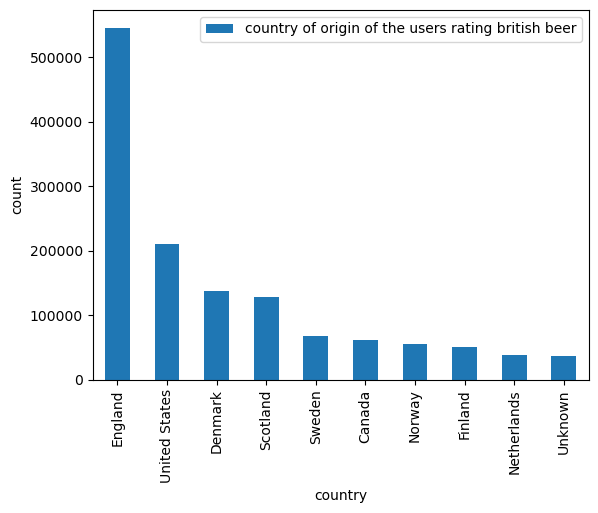

In [98]:
counts_reviews_british_beer = df_british_beers_all.groupby('user_merged_location').count().reset_index()
counts_reviews_british_beer = counts_reviews_british_beer.sort_values('user_name', ascending=False)


axes = counts_reviews_british_beer[:10].plot.bar(x = 'user_merged_location', y='beer_name')
axes.set_ylabel('count')
axes.set_xlabel('country')
axes.legend(['country of origin of the users rating british beer'])


The figure above shows that a big part of the reviews about british beer are from british (England, Scotland) users and from other european countries or canada. 

In [72]:
brexit_date = datetime.datetime(2016, 6, 23, 0, 0, 0)

print('From the '+ str(len(df_british_beers_US_users)) +' US ratings of british beer,')
print(str(len(df_british_beers_US_users[df_british_beers_US_users['date'] < brexit_date])) +' were from before Brexit and only ')
print(str(len(df_british_beers_US_users[df_british_beers_US_users['date'] > brexit_date])) +' are from after the referendum. ')

From the 210658 US ratings of british beer,
204404 were from before Brexit and only 
6254 are from after the referendum. 


We only have 6254 US ratings of british beers after the Brexit. <br>
We will try to work with that, but there is the possibility that the data size will not be sufficient. <br>
Especially if we want to investigate the effect in different federal states

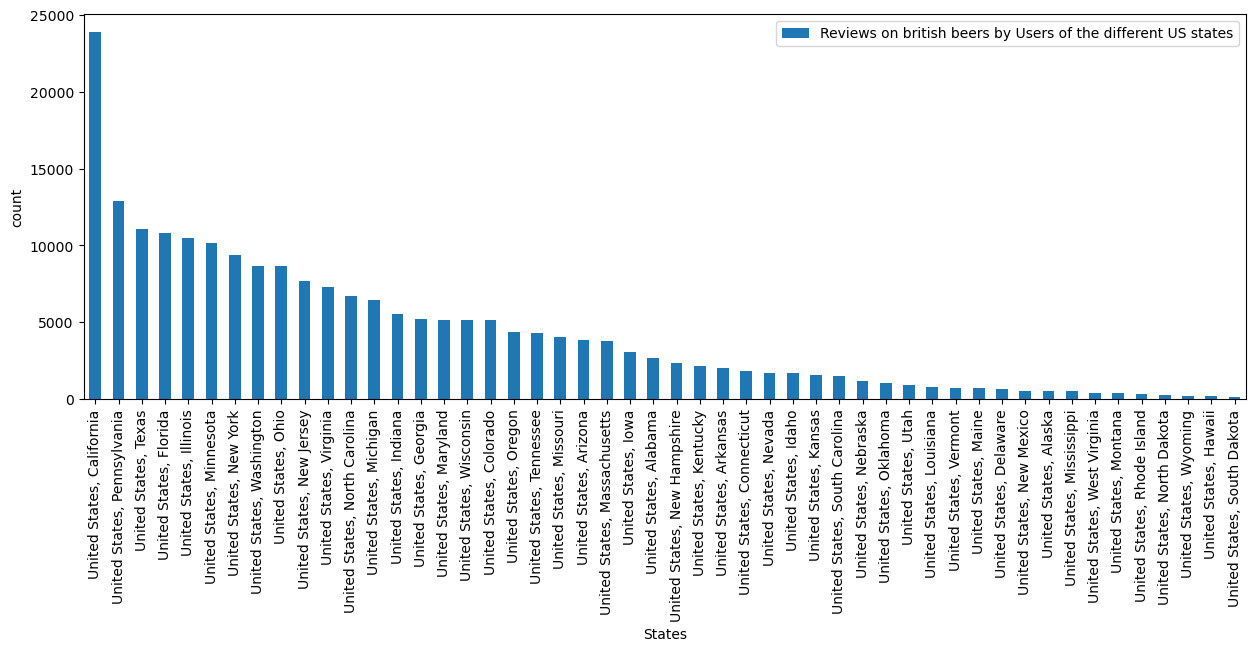

In [97]:
counts_US_reviews_british_beer = df_british_beers_US_users.groupby('user_location').count().reset_index()
counts_US_reviews_british_beer = counts_US_reviews_british_beer.sort_values('user_name', ascending=False)

axes = counts_US_reviews_british_beer.plot.bar(x = 'user_location', y='beer_name', figsize=(15,5))
axes.set_ylabel('count')
axes.set_xlabel('States')
axes.legend(['Reviews on british beers by users of the different US states'])

In [81]:
counts_US_reviews_british_beer['beer_name'].describe()

count       50.000000
mean      4213.160000
std       4535.050689
min        138.000000
25%        744.000000
50%       2507.000000
75%       6238.000000
max      23858.000000
Name: beer_name, dtype: float64

We can see that there are many ratings on british beer in California and fewer ratings in other states. <br>
The lowest number of ratings we find in South Dakota with 138. <br>
One fourth of the states have 744 or less ratings, which can be tough to work with.

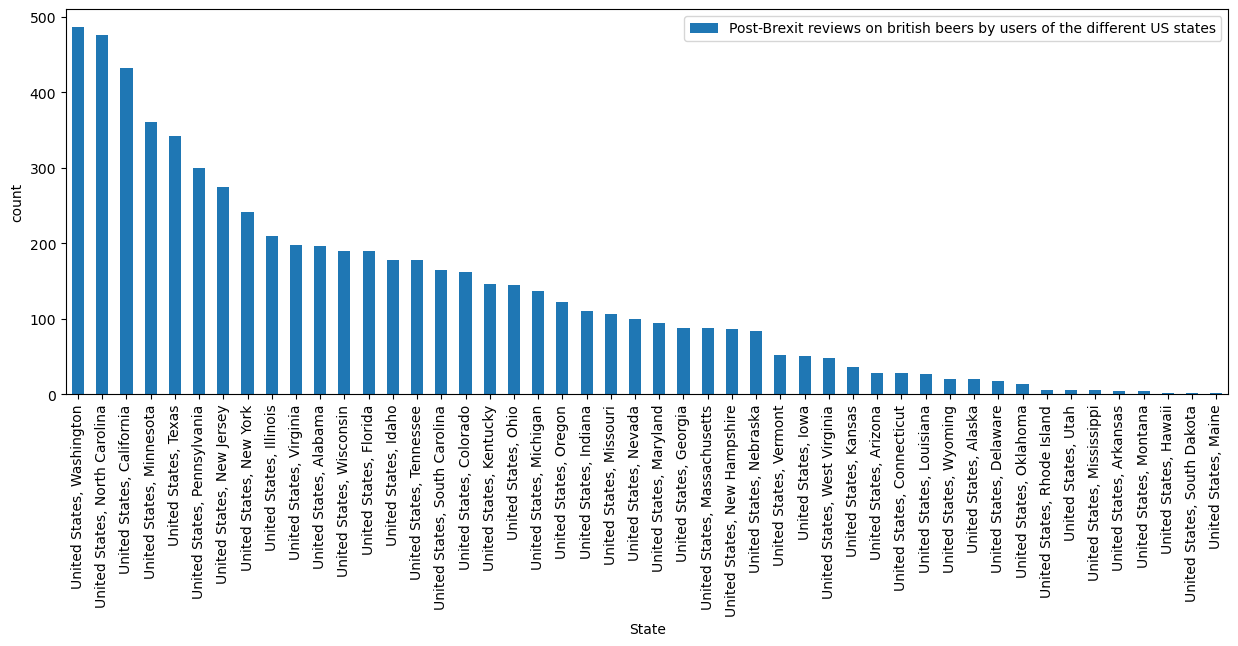

In [99]:
counts_US_reviews_british_beer_postBrexit = df_british_beers_US_users[df_british_beers_US_users['date'] > brexit_date].groupby('user_location').count().reset_index()
counts_US_reviews_british_beer_postBrexit = counts_US_reviews_british_beer_postBrexit.sort_values('user_name', ascending=False)

axes = counts_US_reviews_british_beer_postBrexit.plot.bar(x = 'user_location', y='beer_name', figsize=(15,5))
axes.set_ylabel('count')
axes.set_xlabel('State')
axes.legend(['Post-Brexit reviews on british beers by users of the different US states'])

In [88]:
counts_US_reviews_british_beer_postBrexit['beer_name'].describe()

count     48.000000
mean     130.291667
std      128.431447
min        2.000000
25%       24.500000
50%       97.000000
75%      190.000000
max      486.000000
Name: beer_name, dtype: float64

When plotting the data about the reviews we got about british beer of US users after the Brexit referendum, <br>
then the first thing that catches the eye is that two states don't even show up (count = 48). <br>
Meaning that for two federal states we have no review about british beer after brexit at all. <br>
This can possibly be an effect as well. If there were ratings at some frequency before Brexit, and after Brexit this ratings disappear,
this could also be considered as a correlation between the reviewing behavior of US population and the brexit. <br>
Nevertheless we consider that as sign for a bad base to analyse the data in this context. <br>
Moreover, the state with the highest amount of reviews (Washington) has a mere amount of 486 ratings. <br>
It will be hard to get significant effects with a mean of 130 ratings. <br>
To avoid a simpson paradoxon we should avoid differences in the sample sizes of pre and post Brexit groups. <br>
Should one proceed this analysis I would suggest to take the amount of reviews that are present after the brexit (let's say we have X reviews), <br>
And compare them to the X most recent reviews before Brexit.

We are interested in the influence of international relations of the US with other countries and how these relations affect the behaviour of US beer consumers on the ratings on beers of the countries in question. <br>
As China and Great Britain were not very promising we will try to find other countries which could be more promising.

In [8]:
df_US_reviews = df_reviews_all[df_reviews_all['user_merged_location'] == 'United States']

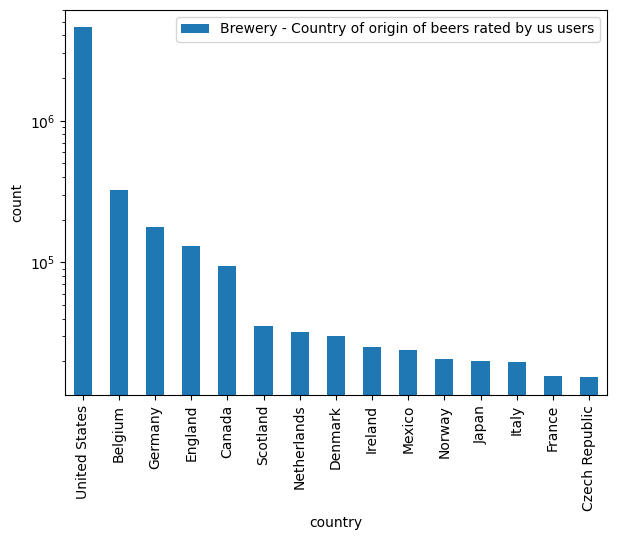

In [100]:
rating_nationality_counts = df_US_reviews.groupby('brewery_merged_location').count().reset_index()
rating_nationality_counts = rating_nationality_counts.sort_values('user_name', ascending=False)


axes = rating_nationality_counts[:15].plot.bar(x = 'brewery_merged_location', y='beer_name', logy=True, figsize=(7,5))
axes.set_ylabel('count')
axes.set_xlabel('country')
axes.legend(['Brewery - Country of origin of beers rated by us users'])

Note that the y-axis is logarithmic. <br>
We see that the big majority of reviews of US users are done on US beers. <br>
So, to find effects of politics on beer reviews, international relations are not the ideal approach given the distribution of the data. <br>

In the next paragraph we will focus on scandals in the context of th Anheuser-Busch brewery (which is a US brewery) and investigate whether there is sufficient data to conduct an analyis.

## Budweiser Anheuser-Busch case

In 2013 Anheuser-Busch was accused of watering down their beer. The suit was filed by Pennsylvania, California and other States. The suits were later thrown out. <br>
There are many more scandals that can be investigated together with their influence on the ratings of the beers.

In [30]:
all_breweries = pd.concat([BA_breweries, RB_breweries], axis = 0)
US_breweries = all_breweries[all_breweries['merged_location'] == 'United States']

In [33]:
len(US_breweries)

14352

In [37]:
US_breweries[US_breweries['name'].str.startswith('Anheuser-Busch')].head()

,location,name,nbr_beers,merged_location
id,,,,
36293,"United States, Colorado",Anheuser-Busch,185,United States
29,"United States, Missouri",Anheuser-Busch,185,United States
84,"United States, Missouri",Anheuser-Busch InBev,216,United States


In [39]:
df_Budweiser_reviews = df_US_reviews[df_US_reviews['brewery_name'].str.startswith('Anheuser')]

In [41]:
len(df_Budweiser_reviews[df_Budweiser_reviews['brewery_merged_location'] == 'United States'])

73971

We have 73971 reviews of US users about beers from the Anheuser-Busch brewery.

# Visualize where most ratings were from:

# Code for Zeina:

This is the code I used to extract the indices of the rows containing words related to can or bottle in their texts. <br>
I added the lists as pickles to the drive. <br>
You can see in the code below how to unpack a pickle into a list again. <br>

Should you need to investigate for other words, you can use the architecture of the code below. <br>
There is a high probability that this is not the most efficient way of doing it, so if you have ideas of improvement I am open :)

In [110]:
words_to_select_can = ['can', 'canned']
words_to_select_bottle = ['bottle', 'bottled']

In [112]:
index_can_R = []
index_bottle_R = []
index_can_B = []
index_bottle_B = []
added_words = []
added_texts = []

k = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [113]:
for index, row in df_RB_reviews.iterrows():
    #extract the text
    text = row['text']
    #split the text into words
    words = text.split(' ')
    #remove all characters that arent letters
    for i, word in enumerate(words):
        words[i] = "".join(list(filter(lambda x: x in k, word)))
    #Check whether a word related to "can" is in the text
    if (len([x for x in words if x in words_to_select_can]) > 0):
        index_can_R.append(index)
    #Check whether a word related to "bottle" is in the text
    if (len([x for x in words if x in words_to_select_bottle]) > 0):
        index_bottle_R.append(index)

In [129]:
with open("../dataframes_Flo/index_bottle_R.bin", "wb") as output:
    pickle.dump(index_bottle_R, output)

with open("../dataframes_Flo/index_can_R.bin", "wb") as output:
    pickle.dump(index_can_R, output)

In [128]:
for index, row in df_BA_reviews.iterrows():
    #extract the text
    text = str(row['text'])
    #split the text into words
    words = text.split(' ')
    #remove all characters that arent letters
    for i, word in enumerate(words):
        words[i] = "".join(list(filter(lambda x: x in k, word)))
    #Check whether a word related to "can" is in the text
    if (len([x for x in words if x in words_to_select_can]) > 0):
        index_can_B.append(index)
    #Check whether a word related to "bottle" is in the text
    if (len([x for x in words if x in words_to_select_bottle]) > 0):
        index_bottle_B.append(index)

In [130]:
with open("../dataframes_Flo/index_bottle_B.bin", "wb") as output:
    pickle.dump(index_bottle_B, output)

with open("../dataframes_Flo/index_can_B.bin", "wb") as output:
    pickle.dump(index_can_B, output)

In [133]:
print('In RB, out of ' + str(len(df_RB_reviews)) + ' reviews, we have ' + str(len(index_bottle_R)) + ' reviews mentioning "bottle" and ' + str(len(index_can_R)) + ' reviews mentioning "cans"')
print('In BA, out of ' + str(len(df_BA_reviews)) + ' reviews, we have ' + str(len(index_bottle_B)) + ' reviews mentioning "bottle" and ' + str(len(index_can_B)) + ' reviews mentioning "cans"')


In RB, out of 7129580 reviews, we have 1041161 reviews mentioning "bottle" and 261858 reviews mentioning "cans"
In BA, out of 2962158 reviews, we have 1058080 reviews mentioning "bottle" and 540167 reviews mentioning "cans"
